# Errors and Noise - getting most of NISQ computers

## Reading:
* Short video describing the performance KPIs: https://www.youtube.com/watch?v=UpKseR066DQ
* Scale, Quality, and Speed: three key attributes to measure the performance of
near-term quantum computers (https://arxiv.org/pdf/2110.14108.pdf)
* https://research.ibm.com/blog/circuit-layer-operations-per-second

## Seeing the noise in practice

In [4]:
%matplotlib inline
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, IBMQ
from qiskit.visualization import *
from qiskit.tools.jupyter import *
import pprint
from qiskit.tools.monitor import backend_overview, backend_monitor
from qiskit.compiler import transpile, assemble
from qiskit.converters import circuit_to_dag
from qiskit.tools.visualization import dag_drawer
from qiskit.transpiler import PassManager
from qiskit.visualization import pass_manager_drawer
from qiskit.transpiler.passes import Unroller

In [5]:
provider = IBMQ.load_account()

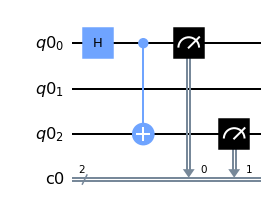

In [6]:
qr = QuantumRegister(3)
cr = ClassicalRegister(2)
circuit = QuantumCircuit(qr, cr)

circuit.h(qr[0])
circuit.cx(qr[0], qr[2])
circuit.measure(qr[0], cr[0])
circuit.measure(qr[2], cr[1])

circuit.draw(output='mpl')

In [16]:
backend = provider.get_backend('ibmq_qasm_simulator')

In [17]:
job = execute(circuit, backend=backend, shots=1024)

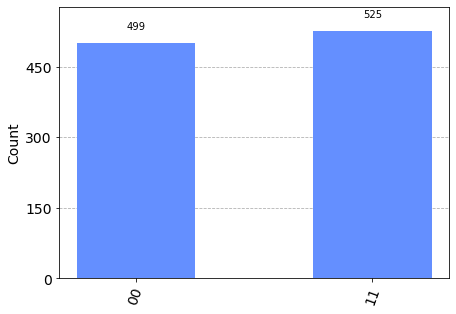

In [18]:
counts = job.result().get_counts()
plot_histogram(counts)

In [19]:
backend = provider.get_backend('ibmq_lima')

In [31]:
#job = execute(circuit, backend=backend, shots=1024)
#job.queue_position()
#job.job_id()
#job.status()

In [20]:
job=backend.retrieve_job('611f836dddbd7b88786ca507')

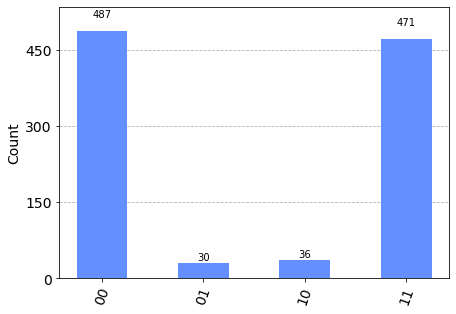

In [21]:
counts2 = job.result().get_counts()
plot_histogram(counts2)

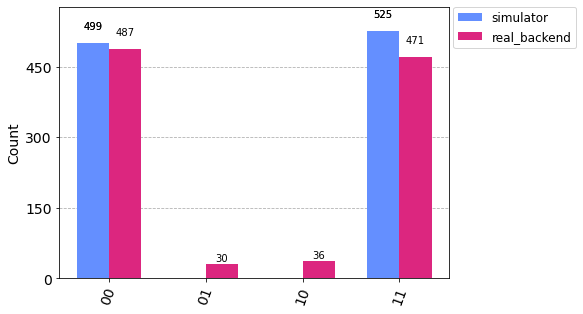

In [24]:
plot_histogram([counts, counts2], legend=["simulator", "real_backend"])

## Analyzing backend properties to understand it's limitatations and be able to tune the algorithms

In [7]:
backend_monitor(backend)

ibmq_lima
Configuration
-------------
    n_qubits: 5
    operational: True
    status_msg: active
    pending_jobs: 19
    backend_version: 1.0.40
    basis_gates: ['id', 'rz', 'sx', 'x', 'cx', 'reset']
    local: False
    simulator: False
    timing_constraints: {'acquire_alignment': 16, 'granularity': 16, 'min_length': 64, 'pulse_alignment': 1}
    meas_map: [[0, 1, 2, 3, 4]]
    open_pulse: False
    measure_esp_enabled: False
    conditional: False
    pulse_num_qubits: 3
    backend_name: ibmq_lima
    rep_delay_range: [0.0, 500.0]
    meas_lo_range: [[6.925143125000001, 7.925143125000001], [6.721646720000001, 7.721646720000001], [6.971842939, 7.971842939], [6.865317232000001, 7.865317232000001], [6.919067567000001, 7.919067567000001]]
    sample_name: family: Falcon, revision: 4, segment: T
    allow_q_object: True
    parallel_compilation: False
    qubit_lo_range: [[4.529753530199341, 5.529753530199341], [4.627736244108125, 5.627736244108125], [4.747353834810967, 5.7473538348

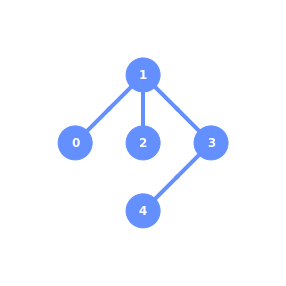

In [8]:
from qiskit.visualization import plot_gate_map
plot_gate_map(backend)

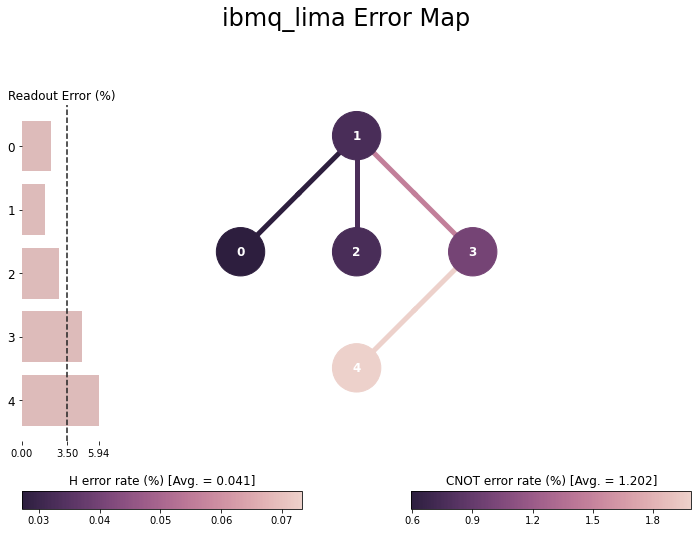

In [9]:
plot_error_map(backend)

# Mitigating readout errors

In [29]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler
service = QiskitRuntimeService(channel="ibm_quantum")

In [43]:
service.backends()

[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_oslo')>]

In [48]:
options = Options()
options.execution.shots = 1000
options.optimization_level = 3
options.resilience_level = 1

backend = "ibmq_lima"

with Session(service=service, backend=backend) as session:  
    sampler = Sampler(session=session, options=options)
    job_sampler = sampler.run(circuits=circuit)
    print('job id:', job_sampler.job_id)

job id: cf8lqgqpm2vc8eqc92eg


In [81]:
print(job_sampler.status())

JobStatus.DONE


In [82]:
counts3=job_sampler.result().quasi_dists[0].binary_probabilities()

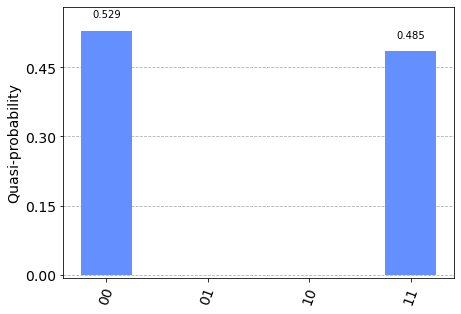

In [83]:
plot_histogram(counts3)

## Comparing (indirectly) quantum states - Hellinger fidelity between two probability distributions

In [89]:
from qiskit.quantum_info.analysis import hellinger_fidelity

hellinger_fidelity(counts, counts2)

0.935132479845868

# How we can analyze circuit size and complexity

* Very important to understand what is our final circuit after transpilation as it directly impacts the results.
* The more gates, the more errors get introduced

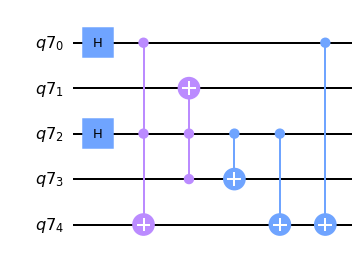

In [69]:
from qiskit import QuantumCircuit, QuantumRegister

q = QuantumRegister(5)
circuit2 = QuantumCircuit(q)
circuit2.h(q[0])
circuit2.h(q[2])
circuit2.ccx(q[0], q[2], q[4])
circuit2.ccx(q[3], q[2], q[1])
circuit2.cx(q[2], q[3])
circuit2.cx(q[2], q[4])
circuit2.cx(q[0], q[4])
circuit2.draw(output='mpl')

In [70]:
# total number of operations in the circuit. no unrolling is done.
circuit2.size()

7

In [72]:
# number of qubits in the circuit
circuit2.width()

5

In [73]:
circuit2.depth()

6

In [74]:
# a breakdown of operations by type
circuit2.count_ops()

OrderedDict([('cx', 3), ('h', 2), ('ccx', 2)])

In [40]:
# number of unentangled subcircuits in this circuit.
# each subcircuit can in principle be executed on a different quantum processor!
circuit2.num_tensor_factors()

1

# Transpilation

In [91]:
backend = provider.get_backend('ibmq_lima')
circuit2_transpiled = transpile(circuit2, backend)

In [92]:
circuit2_transpiled.size()

59

In [93]:
circuit2_transpiled.width()

5

In [94]:
circuit2_transpiled.depth()

38

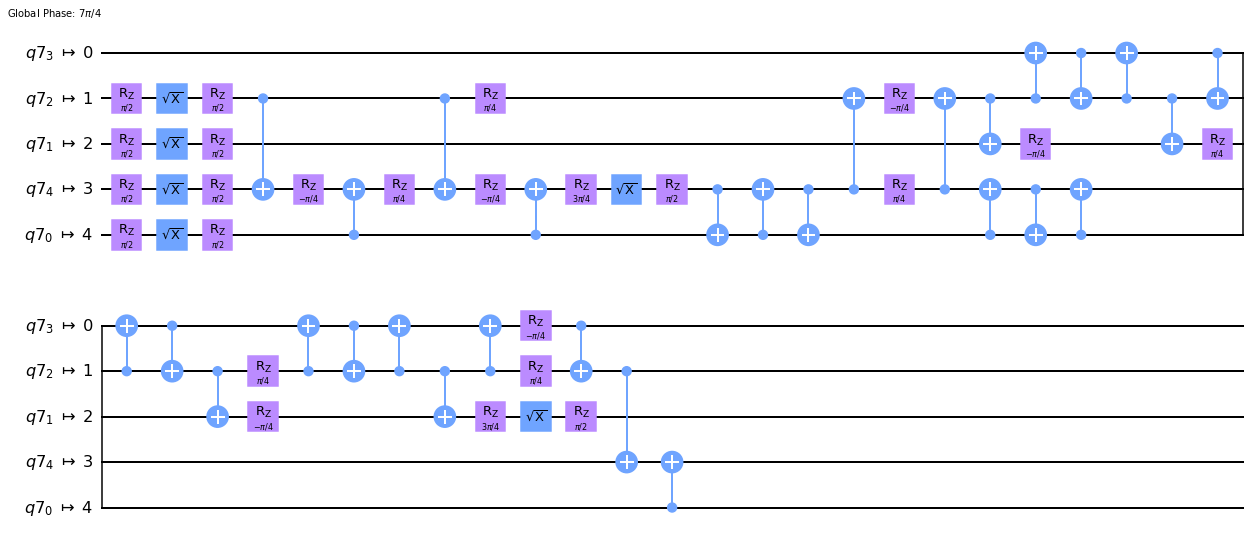

In [95]:
circuit2_transpiled.draw('mpl')

# Exercise 1:

Which statement is correct for currently existing quantum computers:
1. Error of implementing CNOT gate is much lower than Hadamard gate
1. CNOT gates have approximately 100 times bigger errors than single qubit gates
1. Two qubit gates have bigger errors than single qubit gates
1. Two qubit gates have bigger errors, but take less time to be applied

# Exercise 2

Given the following code, what is the depth and width of the circuit?

`qc = QuantumCircuit(2, 2)
qc.h(0)
qc.barrier(0)
qc.cx(0,1)
qc.barrier([0,1])`

# Exercise 3

List at least 5 reasons which may cause incorrect result generated by a NISQ computer.

## Homework

Run the following circuit on a read device in such a way that the Hellinger fidelity of the state compared to simulator would be as close to 1 as possible. 

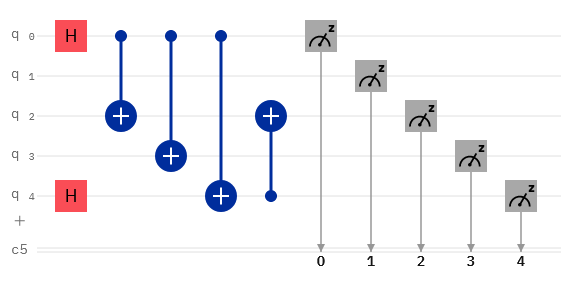